# Reason for this file: Find out how to ammend the game-features

In [358]:
import numpy as np
import pickle
from sklearn import model_selection
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA

with open("my-saved-data.pt", "rb") as file:
    data_sample = pickle.load(file)
X_train, X_test, y_train, y_test = model_selection.train_test_split\
                                   (data_sample[:,:-1], data_sample[:,-1], test_size=.4, random_state=0)

First question: How bad are the rewards right now?

0 9436
(15728, 18)


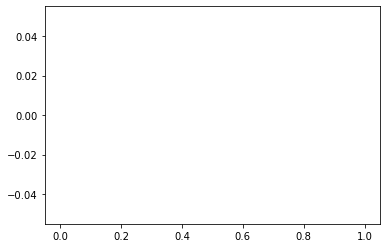

In [360]:
plt.hist(np.sort(y_train[np.abs(y_train) < 5]))
print(len(np.sort(y_train[np.abs(y_train) < 5])), len(np.sort(y_train[np.abs(y_train) >= 5])))
print(data_sample.shape)# Ausreißer-Verhältnis

-3092.1420279300464 1529.5990260514614 -10506.623386803667 380.2932899250277
-10506.623386803667 380.2932899250277


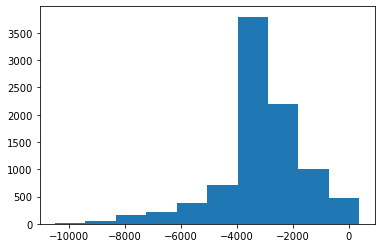

In [355]:
plt.hist(np.sort(y_train))
print(np.mean(y_train), np.std(y_train), np.min(data_sample[:,-1]), np.max(data_sample[:,-1]))
print(np.min(data_sample), np.max(data_sample))

First answer: Most of the features are in between (-5, 5). That is actually not so bad. Question: How are we to deal with the (few) outliers?

Second question: Can we reduce matrix features?
How do we deal with missing data? Where does it come from?

In [369]:
X_mean = np.mean(X_train, axis = 0)
X_std = np.std(X_train, axis = 0)
X_centered = (X_train - X_mean)/X_std
pca = PCA(n_components=17, svd_solver='full')
pca.fit(X_centered)
print(pca.explained_variance_ratio_)
print(pca.get_covariance())
pca.transform(np.ones(shape=(1,17)))

[0.13902034 0.13048983 0.12901153 0.12210724 0.07912882 0.05964137
 0.05639289 0.05430229 0.05248576 0.03428167 0.03206802 0.02926345
 0.02640364 0.02324831 0.01132089 0.0109055  0.00992845]
[[ 1.00010599e+00 -1.21969793e-01  5.07304866e-01 -4.14528662e-02
   3.79314752e-02 -1.24712741e-01  5.23302815e-01 -8.05974599e-02
   1.99386991e-01 -6.15966624e-02 -7.27441415e-02 -1.82236742e-01
  -1.73977747e-01 -1.55167739e-01 -1.55527649e-01 -5.79936646e-02
  -3.99483466e-02]
 [-1.21969793e-01  1.00010599e+00 -1.28575378e-01 -2.01096757e-01
   1.96283194e-01 -2.86230741e-01 -1.47371283e-01  4.54640524e-01
  -1.50819119e-01 -1.22141890e-01  5.95565863e-03 -1.69716951e-01
   3.05748022e-03 -1.71386992e-01 -2.87461731e-03  1.20895043e-01
  -1.07347686e-01]
 [ 5.07304866e-01 -1.28575378e-01  1.00010599e+00 -6.76725204e-02
   5.38992471e-02 -6.30655763e-02  1.94828580e-01 -1.26277227e-01
   5.16670853e-01 -8.30339162e-02  5.34996552e-02 -2.01335473e-01
   2.03204982e-01 -1.68535019e-01  1.60520780

array([[-1.49708225,  1.20534452,  0.336065  ,  0.86438832, -2.25593116,
         0.87144506,  0.67099698,  0.9065868 ,  1.56540161,  0.28177681,
        -0.06429841, -1.090958  ,  0.88805244,  0.84553302,  0.30209253,
         0.02190363, -0.07414211]])

In [372]:
from sklearn import linear_model
def omp_regression(X, y, T):
    A = np.zeros(shape = (X.shape))
    B = np.copy(X)
    r_t = y
    regr = linear_model.LinearRegression()
    beta = np.zeros(shape = (X.shape[1], T))
    ind = []
    assert r_t.size == X.shape[0]
    for i in range(0,T):
        j = np.argmax(np.abs(np.matmul(B.T, r_t)))
        if j in ind:
            beta[:,i][ind] = regr.coef_
            continue
        regr = linear_model.LinearRegression()
        ind.append(j)
        A[:,j] = B[:,j]
        B[:,j] = np.zeros(shape=(X.shape[0],))
        X_t = A[:,ind]
        regr.fit(X_t, y)
        beta[:,i][ind] = np.array(regr.coef_)
    return beta
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

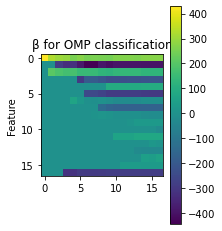

In [411]:
t = 17
# First without standardization:
beta = omp_regression(X=X_centered, y = y_train, T = t)

#plt.figure(figsize=(10,10))
plt.subplot(121)
plt.ylabel('Feature')
plt.title('β for OMP classification')
plt.imshow(beta)
plt.colorbar()
dateiname = "/Users/konradgoldenbaum/Documents/Rule_comb_train_omp.png"
plt.savefig(dateiname,  format='png',  dpi=800)
plt.show()



In [34]:
def ewma_vectorized(data, alpha, offset=None, dtype=None, order='C', out=None):
    """
    Calculates the exponential moving average over a vector.
    Will fail for large inputs.
    :param data: Input data
    :param alpha: scalar float in range (0,1)
        The alpha parameter for the moving average.
    :param offset: optional
        The offset for the moving average, scalar. Defaults to data[0].
    :param dtype: optional
        Data type used for calculations. Defaults to float64 unless
        data.dtype is float32, then it will use float32.
    :param order: {'C', 'F', 'A'}, optional
        Order to use when flattening the data. Defaults to 'C'.
    :param out: ndarray, or None, optional
        A location into which the result is stored. If provided, it must have
        the same shape as the input. If not provided or `None`,
        a freshly-allocated array is returned.
    """
    data = np.array(data, copy=False)

    if dtype is None:
        if data.dtype == np.float32:
            dtype = np.float32
        else:
            dtype = np.float64
    else:
        dtype = np.dtype(dtype)

    if data.ndim > 1:
        # flatten input
        data = data.reshape(-1, order)

    if out is None:
        out = np.empty_like(data, dtype=dtype)
    else:
        assert out.shape == data.shape
        assert out.dtype == dtype

    if data.size < 1:
        # empty input, return empty array
        return out

    if offset is None:
        offset = data[0]

    alpha = np.array(alpha, copy=False).astype(dtype, copy=False)

    # scaling_factors -> 0 as len(data) gets large
    # this leads to divide-by-zeros below
    scaling_factors = np.power(1. - alpha, np.arange(data.size + 1, dtype=dtype),
                               dtype=dtype)
    # create cumulative sum array
    np.multiply(data, (alpha * scaling_factors[-2]) / scaling_factors[:-1],
                dtype=dtype, out=out)
    np.cumsum(out, dtype=dtype, out=out)

    # cumsums / scaling
    out /= scaling_factors[-2::-1]

    if offset != 0:
        offset = np.array(offset, copy=False).astype(dtype, copy=False)
        # add offsets
        out += offset * scaling_factors[1:]

    return out

1502 -3594.6856787247916


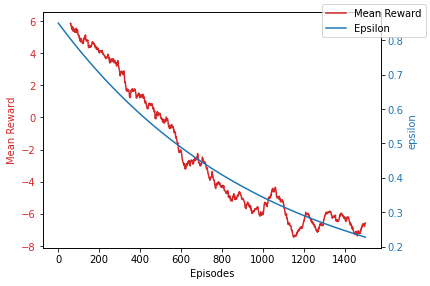

In [518]:
with open("rewards.pt", "rb") as file:
    re = pickle.load(file)
#re = ewma_vectorized(re, alpha=0.1, offset=0, dtype=None, order='C', out=None)
windowSize = 60

# Get PANDAS exponential weighted moving average
ewm_pd = np.array(pd.DataFrame(re).rolling(window=windowSize).mean())

length = len(re)
y = np.exp(-(np.arange(0, length) + 1)/1000)*0.8 + 0.05
fig, ax1 = plt.subplots()
#plt.figure(figsize=(16, 12), dpi=800)
#fig.set_size_inches(18.5, 10.5)
color = 'tab:red'
ax1.set_xlabel('Episodes')
ax1.set_ylabel('Mean Reward', color=color)
ax1.plot(range(length), ewm_pd, color=color, label="Mean Reward")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('epsilon', color=color)  # we already handled the x-label with ax1
ax2.plot(range(length), y, color = color,label="Epsilon")
ax2.tick_params(axis='y', labelcolor=color)
dateiname = "/Users/konradgoldenbaum/Documents/reward_rule_coin_train.png"
fig.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.savefig(dateiname, format='png',  dpi=800)
print(length, np.sum(re))

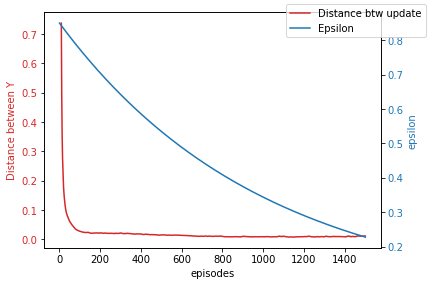

In [519]:
with open("Y_Convergence.pt", "rb") as file:
    re = pickle.load(file)
length = len(re)
y = np.exp(-(np.arange(0, length) + 1)/1000)*0.8 + 0.05
windowSize = 10

# Get PANDAS exponential weighted moving average
re = np.array(pd.DataFrame(re).rolling(window=windowSize).mean())
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('episodes')
ax1.set_ylabel('Distance between Y', color=color)
ax1.plot(range(length), re, color=color, label="Distance btw update")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
dateiname = "/Users/konradgoldenbaum/Documents/Y_rule_coin_train.png"
color = 'tab:blue'
ax2.set_ylabel('epsilon', color=color)  # we already handled the x-label with ax1
ax2.plot(range(length), y, color = color, label="Epsilon")
ax2.tick_params(axis='y', labelcolor=color)
fig.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.savefig(dateiname, format='png', dpi=800)
plt.show()

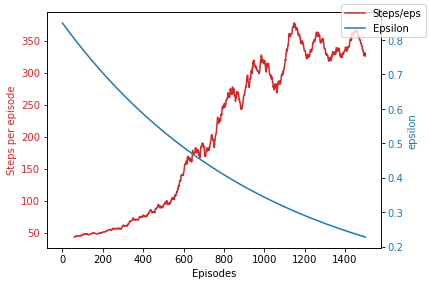

In [520]:
with open("steps.pt", "rb") as file:
    re = pickle.load(file)
windowSize = 60

# Get PANDAS exponential weighted moving average
ewm_pd = np.array(pd.DataFrame(re).rolling(window=windowSize).mean())

length = len(re)
y = np.exp(-(np.arange(0, length) + 1)/1000)*0.8 + 0.05
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Episodes')
ax1.set_ylabel('Steps per episode', color=color)
ax1.plot(range(length), ewm_pd, color=color, label="Steps/eps")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('epsilon', color=color)  # we already handled the x-label with ax1
ax2.plot(range(length), y, color = color, label="Epsilon")
ax2.tick_params(axis='y', labelcolor=color)
dateiname = "/Users/konradgoldenbaum/Documents/steps_rule_coin_train.png"
fig.tight_layout()
fig.legend()# otherwise the right y-label is slightly clipped
plt.show()
fig.savefig(dateiname, format='png', dpi=800)